# Q1: Simple CNN network for PASCAL multi-label classification (20 points)
Now let’s try to recognize some natural images. We provided some starter code for this task. The following steps will guide you through the process.


## 1.1 Setup the dataset
We start by modifying the code to read images from the PASCAL 2007 dataset. The important thing to note is that PASCAL can have multiple objects present in the same image. Hence, this is a multi-label classification problem, and will have to be tackled slightly differently.


First, download the data. `cd` to a location where you can store 0.5GB of images. Then run:
```
wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
tar -xf VOCtrainval_06-Nov-2007.tar

wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
tar -xf VOCtest_06-Nov-2007.tar
cd VOCdevkit/VOC2007/
```

## 1.2 Write a dataloader with data augmentation (5 pts)
**Dataloader** The first step is to write a [pytorch data loader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) which loads this PASCAL data. Browse the folders and files under `VOCdevkit` to understand the structure and labeling. Complete the functions `preload_anno` and `__getitem__` in `voc_dataset.py` according to the following instructions and the instructions in the code. More information about the dataset can be found [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/devkit_doc_07-Jun-2007.pdf). We will use data in ‘trainval’ for training and ‘test’ for testing.

- `preload_anno`: This function will be called when the dataloader is initialized. We will load the annotations under folder `Annotations`. Each .xml file in the `Annotations` folder corresponds to the image with the same name under `JPEGImages`. In this function, we need to load `label` and `weight` vectors for each image according to the .xml file. 
- The labels should be 0 by default. Assign 1 for each class label in the .xml file. For example, in 000001.xml, the label vector should have 1s at the class indices correspond to 'dog' and 'person'. The rest of the vector should be 0.
- The weights should be 1 by default. For each class label in the image, if 'difficult'=1 (which means it is ambiguous), we will assign 0 for the weight vector at this class index. This weight will be used when we calculate the test performance. We will not consider the ambiguous labels during testing.

- `__getitem__`: This function will be called when the dataloader is called during training. It takes as input the index, and returns a tuple - `(image, label, weight)`. You need to load the image from the `JPEGImages` folder and load the corresponding label and weight using `self.anno_list`.


**Data Augmentation** Modify `__getitem__` to randomly *augment* each datapoint using [TORCHVISION.TRANSFORMS](https://pytorch.org/vision/stable/transforms.html).  Make sure the data augmentation is only used for training data (based on self.split). Please describe what data augmentation you implement.

- Before any augmentation, resize all the images based on `self.size`.

* **Hint**: Since we are training a model from scratch on this small dataset, it is important to perform basic data augmentation to avoid overfitting. Add random crops and left-right flips when training, and do a center crop when testing, etc. As for natural images, another common practice is to subtract the mean values of RGB images from ImageNet dataset. The mean values for RGB images are: `[123.68, 116.78, 103.94]`. You may also rescale the images to `[−1, 1]`. There is no "correct" answer here! Feel free to search online about the data augmentation methods people usually use.

### DESCRIBE YOUR AUGMENTATION PIPELINE HERE**
**Train Augmentations:**

transform.Resize((self.size, self.size))

transforms.RandomHorizontalFlip()

transforms.ToTensor()

transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

For training using the SimpleCNN, the augmentation pipeline after resizing, included a random horizontal flip, after which the tensor was normalized. This pipeline worked best for this network.

<br>

**Test Augmentations:**

transforms.Resize((self.size, self.size))

transforms.ToTensor()

transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

For testing using the SimpleCNN, after resizing, normalizing the tensor was the only operation performed.

## 1.3 Measure Performance (5 pts)
To evaluate the trained model, we will use a standard metric for multi-label evaluation - [mean average precision (mAP)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). Please implement `eval_dataset_map` in `utils.py` - this function will evaluate a model's map score using a given dataset object. You will need to make predictions on the given dataset with the model and call `compute_ap` to get average precision.


Please describe how to compute AP for each class(not mAP).

**ANSWER**

The average precision for each class is calculated based on the percentage of true positives, compared to the total number of predictions which include both the true positives and the false positives of each image class. Essentially it measures how accurate our predictions are. Therefore the precision values are then averaged over each class to calculate the class average precision (AP).

## 1.4 Let's Start Training! (5 pts)
Fill out the loss function for multi-label classification in `trainer.py` and start training. In this question, you will use the model that you finished in the previous question (with proper non-linearities).

Initialize a fresh model and optimizer. Then run your training code for 5 epochs and print the mAP on test set. The resulting mAP should be around 0.24. Make sure to tune the hyperparameters.

In [30]:
import torch
import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset

# create hyperparameter argument class
# Use image size of 64x64 in Q1. We will use a default size of 224x224 for the rest of the questions.
args = ARGS(batch_size= 20, epochs=5, inp_size=64, test_batch_size=32, lr = 0.001, gamma=0.9, step_size=1)
print(args)

args.batch_size = 20
args.device = cuda
args.epochs = 5
args.gamma = 0.9
args.inp_size = 64
args.log_every = 100
args.lr = 0.001
args.save_at_end = True
args.save_freq = 10
args.step_size = 1
args.test_batch_size = 32
args.val_every = 100



In [31]:
# initializes the model
model = SimpleCNN(num_classes=len(VOCDataset.CLASS_NAMES), inp_size=64, c_dim=3)
# initializes Adam optimizer and simple StepLR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
# trains model using your training code and reports test map
test_ap, test_map = trainer.train(args, model, optimizer, scheduler)
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.689804
Validation MAP =  0.06835668641091727
Train Epoch: 0 [100 (40%)]	Loss: 0.233697
Validation MAP =  0.12075095122484583
Train Epoch: 0 [200 (80%)]	Loss: 0.185883
Validation MAP =  0.14962108185374517
Train Epoch: 1 [300 (20%)]	Loss: 0.225765
Validation MAP =  0.1872532896754321
Train Epoch: 1 [400 (59%)]	Loss: 0.179713
Validation MAP =  0.19343623962443304
Train Epoch: 1 [500 (99%)]	Loss: 0.214975
Validation MAP =  0.21642378757365405
Train Epoch: 2 [600 (39%)]	Loss: 0.212825
Validation MAP =  0.22348407010838794
Train Epoch: 2 [700 (79%)]	Loss: 0.201381
Validation MAP =  0.22722938098108997
Train Epoch: 3 [800 (19%)]	Loss: 0.156733
Validation MAP =  0.224197077705443
Train Epoch: 3 [900 (59%)]	Loss: 0.182950
Validation MAP =  0.24676095677253623
Train Epoch: 3 [1000 (98%)]	Loss: 0.165711
Validation MAP =  0.2502095401236013
Train Epoch: 4 [1100 (38%)]	Loss: 0.139284
Validation MAP =  0.24844596667491342
Train Epoch: 4 [1200 (78%)]	Loss: 0.195317
Va

[TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) is an awesome visualization tool. It was firstly integrated in [TensorFlow](https://www.tensorflow.org/). It can be used to visualize training losses, network weights and other parameters.

To use TensorBoard in Pytorch, there are two options: [TensorBoard in Pytorch](https://pytorch.org/docs/stable/tensorboard.html) (for Pytorch >= 1.1.0) or [TensorBoardX](https://github.com/lanpa/tensorboardX) - a third party library. Following these links to add code in `trainer.py` to visualize the testing MAP and training loss in Tensorboard. *You may have to reload the kernel for these changes to take effect.*

Show clear screenshots of the learning curves of testing MAP and training loss for 5 epochs (batch size=20, learning rate=0.001). Please evaluate your model to calculate the MAP on the testing dataset every 100 iterations.

In [32]:
args = ARGS(epochs=5, batch_size=20, lr=0.001, gamma=0.9, step_size=1, inp_size=64)
model = SimpleCNN(num_classes=len(VOCDataset.CLASS_NAMES), inp_size=64, c_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler)
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.689675
Validation MAP =  0.06670865358670464
Train Epoch: 0 [100 (40%)]	Loss: 0.174531
Validation MAP =  0.11740428138914756
Train Epoch: 0 [200 (80%)]	Loss: 0.189493
Validation MAP =  0.1548247224665475
Train Epoch: 1 [300 (20%)]	Loss: 0.223714
Validation MAP =  0.18686707250730722
Train Epoch: 1 [400 (59%)]	Loss: 0.169717
Validation MAP =  0.19500527991497058
Train Epoch: 1 [500 (99%)]	Loss: 0.184541
Validation MAP =  0.21468805966284704
Train Epoch: 2 [600 (39%)]	Loss: 0.172162
Validation MAP =  0.20916867329605654
Train Epoch: 2 [700 (79%)]	Loss: 0.194230
Validation MAP =  0.22829943373401101
Train Epoch: 3 [800 (19%)]	Loss: 0.186650
Validation MAP =  0.2314852248246606
Train Epoch: 3 [900 (59%)]	Loss: 0.165986
Validation MAP =  0.23247545495615865
Train Epoch: 3 [1000 (98%)]	Loss: 0.143803
Validation MAP =  0.2404478805405324
Train Epoch: 4 [1100 (38%)]	Loss: 0.165895
Validation MAP =  0.24054945462309454
Train Epoch: 4 [1200 (78%)]	Loss: 0.216775
V

**INSERT YOUR TENSORBOARD SCREENSHOTS HERE**

In [39]:
from IPython.display import Image

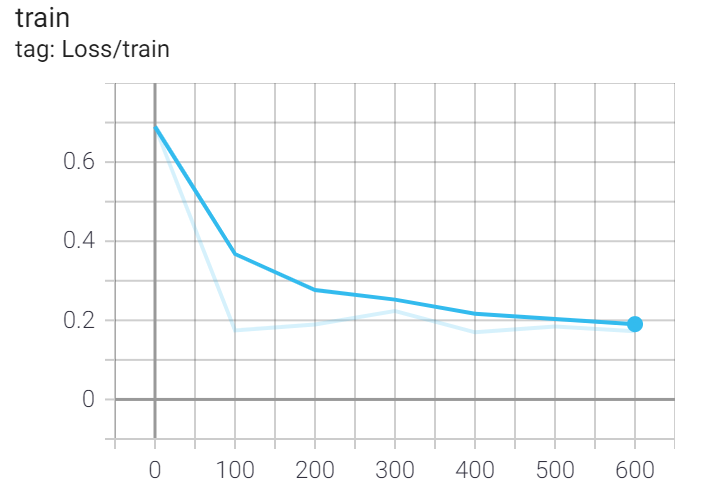

In [37]:
Image("./images/q1_train.png")

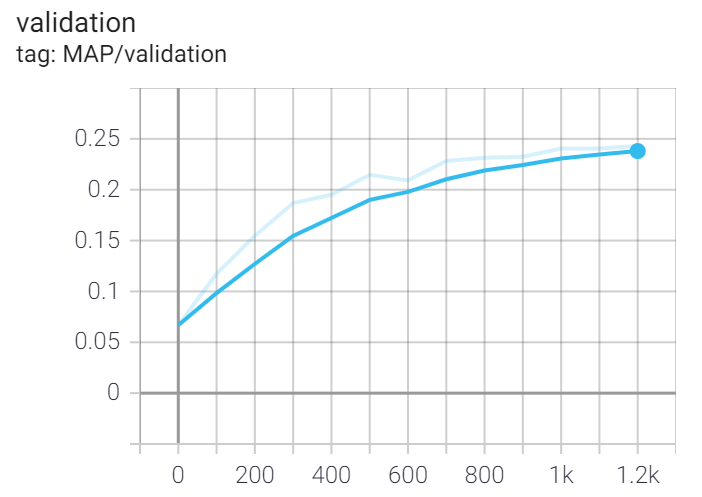

In [36]:
Image("./images/q1_validation.png")